In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [56]:
df = pd.read_csv("./data_rfm.csv")
df.drop(columns='Unnamed: 0',inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [58]:
df_not_na = df[df['CustomerID'].notna()]
df_not_na = df_not_na.sample(10000,random_state=0)
df_not_na.count()

InvoiceNo      10000
StockCode      10000
Description    10000
Quantity       10000
InvoiceDate    10000
UnitPrice      10000
CustomerID     10000
Country        10000
dtype: int64

Tính toán RFM

Tính R - Recency

In [59]:
df_not_na.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [60]:
df_not_na['InvoiceDate'] = pd.to_datetime(df_not_na['InvoiceDate'])

In [61]:
df_not_na.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
209444,555240,20727,LUNCH BAG BLACK SKULL.,3,2011-06-01 13:07:00,1.65,15039.0,United Kingdom
389683,570488,21739,COSY SLIPPER SHOES SMALL GREEN,2,2011-10-10 17:12:00,2.46,14096.0,United Kingdom
184515,552694,22938,CUPCAKE LACE PAPER SET 6,12,2011-05-10 15:25:00,1.95,12749.0,United Kingdom
98089,544667,22896,PEG BAG APPLES DESIGN,50,2011-02-22 15:10:00,2.10,17511.0,United Kingdom
268149,560392,15034,PAPER POCKET TRAVELING FAN,96,2011-07-18 13:30:00,0.14,13911.0,United Kingdom


Lấy ngày lớn nhất trong InvoiceDate

In [62]:
import datetime
current_date =  df_not_na['InvoiceDate'].max() + datetime.timedelta(days=1)

Tính M - Monetary

In [63]:
df_not_na['TotalPay'] = df_not_na['Quantity']*df_not_na['UnitPrice']

In [64]:
df_not_na.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPay
209444,555240,20727,LUNCH BAG BLACK SKULL.,3,2011-06-01 13:07:00,1.65,15039.0,United Kingdom,4.95
389683,570488,21739,COSY SLIPPER SHOES SMALL GREEN,2,2011-10-10 17:12:00,2.46,14096.0,United Kingdom,4.92
184515,552694,22938,CUPCAKE LACE PAPER SET 6,12,2011-05-10 15:25:00,1.95,12749.0,United Kingdom,23.40
98089,544667,22896,PEG BAG APPLES DESIGN,50,2011-02-22 15:10:00,2.10,17511.0,United Kingdom,105.00
268149,560392,15034,PAPER POCKET TRAVELING FAN,96,2011-07-18 13:30:00,0.14,13911.0,United Kingdom,13.44


Tính R,F,M theo CustomerID

In [65]:
df_customer = df_not_na.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (current_date-x.max()).days,
    'InvoiceNo':'count',
    'TotalPay':'sum'
})

In [66]:
df_customer

,InvoiceDate,InvoiceNo,TotalPay
CustomerID,,,
12347.0,40,8,243.50
12349.0,19,2,34.80
12354.0,232,1,20.40
12355.0,214,1,19.90
12356.0,326,2,172.80
...,...,...,...
18270.0,240,1,-38.25
18272.0,46,3,50.55
18281.0,181,1,16.50


In [67]:
df_customer.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPay':'Monetary'},inplace=True)

Scale dữ liệu

In [68]:
# Tien hanh scale du lieu

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_customer)

df_customers_t = scaler.transform(df_customer)

In [69]:
df_customers_t

array([[-0.65954171,  0.58880779,  0.44402342],
       [-0.8630973 , -0.23989995, -0.10728761],
       [ 1.20153799, -0.3780179 , -0.14532728],
       ...,
       [ 0.7071887 , -0.3780179 , -0.15562969],
       [ 0.17406691, -0.3780179 , -0.16553586],
       [-1.00849415,  2.24622325, -0.04594865]])

Chọn số cụm bằng Elbow

Text(0, 0.5, 'SSE')

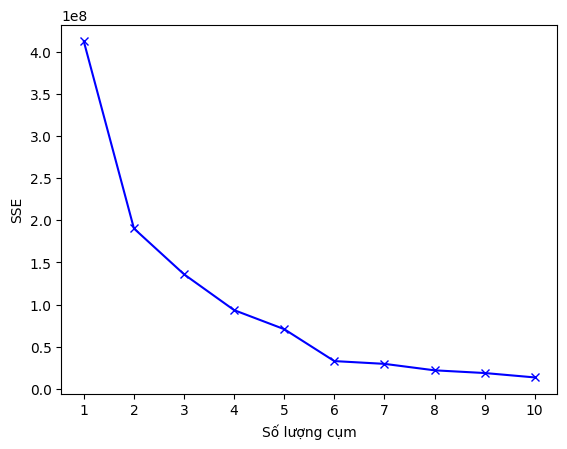

In [70]:
K=10
losses = []
for i in range(1,K+1):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(df_customer)
    losses.append(kmeans.inertia_)

plt.plot(range(1,K+1),losses,'bx-')
plt.xticks(range(1,K+1))
plt.xlabel("Số lượng cụm")
plt.ylabel("SSE")

Text(0, 0.5, 'SSE')

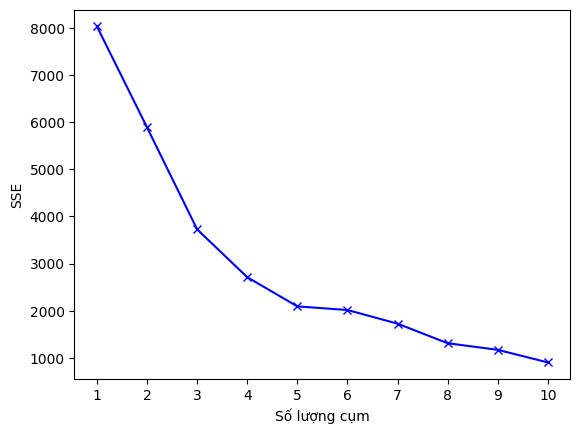

In [71]:
K=10
losses = []
for i in range(1,K+1):
    kmeans = KMeans(n_clusters=i,random_state=0)
    kmeans.fit(df_customers_t)
    losses.append(kmeans.inertia_)

plt.plot(range(1,K+1),losses,'bx-')
plt.xticks(range(1,K+1))
plt.xlabel("Số lượng cụm")
plt.ylabel("SSE")

Thực hiện phân cụm

In [72]:
kmeans = KMeans(n_clusters=3,random_state=0)
kmeans.fit(df_customer)
label_cluster = kmeans.predict(df_customer)


In [73]:
kmeans_t = KMeans(n_clusters=3,random_state=0)
kmeans_t.fit(df_customers_t)
label_cluster_t=kmeans_t.predict(df_customers_t)

In [74]:
df_customer['cluster'] = label_cluster

In [75]:
df_customer['cluster_t'] = label_cluster_t

In [76]:
df_customer.groupby('cluster').mean()

,Recency,Frequency,Monetary,cluster_t
cluster,,,,
0,108.979206,3.385255,49.898465,0.582231
1,11.250000,52.500000,7515.072500,1.000000
2,30.592593,30.962963,1472.815926,0.185185


In [77]:
df_customer.groupby('cluster_t').mean()

,Recency,Frequency,Monetary,cluster
cluster_t,,,,
0,50.062698,4.181770,78.123762,0.024236
1,7.428571,93.142857,4739.131429,1.428571
2,251.686122,1.830091,26.400700,0.002594


In [78]:
df_customer

,Recency,Frequency,Monetary,cluster,cluster_t
CustomerID,,,,,
12347.0,40,8,243.50,0,0
12349.0,19,2,34.80,0,0
12354.0,232,1,20.40,0,2
12355.0,214,1,19.90,0,2
12356.0,326,2,172.80,0,2
...,...,...,...,...,...
18270.0,240,1,-38.25,0,2
18272.0,46,3,50.55,0,0
18281.0,181,1,16.50,0,2


Vẽ đồ thị 3 chiều

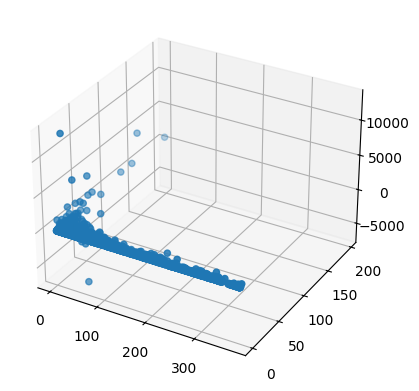

In [79]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(df_customer['Recency'],df_customer['Frequency'],df_customer['Monetary'])

Biến đổi dữ liệu về 2 chiều

In [80]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=123).fit_transform(df_customer)
X_tsne

array([[ 38.54441  ,  10.018152 ],
       [  3.3839808, -41.05006  ],
       [ -4.7580113,  51.165157 ],
       ...,
       [-19.097324 ,  37.258465 ],
       [-29.26932  ,  15.6179905],
       [ 17.468315 , -39.01681  ]], dtype=float32)

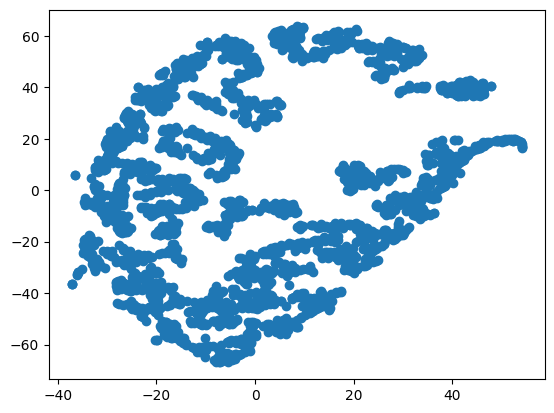

In [81]:
plt.scatter(X_tsne[:,0],X_tsne[:,1])